In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.integrate import solve_ivp
from torch.func import jacfwd,vmap
from torchmin import Minimizer

In [2]:
d = 3 #dimension of the phase space
t_min = 0. #initial time
t_max = 1e6 #final time
y0 = np.array([1.,0.,0])

In [3]:
class activation(nn.Module):
        def __init__(self,):
            super().__init__()
        def derivative(self,x):
            return 1-self.forward(x)**2
        def forward(self,x):
            return torch.tanh(x)

def mat_batch_mats(M,mats):
    return torch.einsum('ij,bjk->bik',M,mats)

class network(nn.Module):
        def __init__(self,t_0,t_1,num_hidden=5):
            super().__init__()
            
            self.num_hidden = num_hidden
            self.t_0 = t_0
            self.t_1 = t_1
            
            self.input_dim = 3
            self.output_dim = 3
            
            self.M = torch.rand(self.num_hidden,self.input_dim)*2-1
            self.a = torch.rand(self.num_hidden,1)*2-1
            self.b = torch.rand(self.num_hidden)*2-1
            self.W = nn.Parameter(torch.rand(self.output_dim,self.num_hidden)*2-1)
            
            self.nl = activation()
        
        def parametric(self,t,x):
            t = t.reshape(-1,1)
            x = x.reshape(-1,d)
            update_t = F.linear(t,self.a)
            update_x = F.linear(x,self.M,self.b)
            hidden = self.nl(update_x+update_t)
            return F.linear(hidden,self.W)
        
        def derivative_x0(self,t,x):
            b,n = x.shape
            t_0 = torch.zeros_like(t)
            Id = torch.eye(n).unsqueeze(0).repeat(b,1,1).to(x.device)
            vec = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t,self.a))
            vec_0 = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t_0,self.a))
            diag = torch.diag_embed(vec)
            diag_0 = torch.diag_embed(vec_0)
            Wdiag = mat_batch_mats(self.W,diag)
            Wdiag_0 = mat_batch_mats(self.W,diag_0)
            return Id + torch.einsum('bij,jk->bik',Wdiag-Wdiag_0,self.M)
        
        def derivative_t(self,t,x):
            vec = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t,self.a))
            return F.linear(torch.einsum('ip,bi->bi',self.a,vec),self.W)
        
        def derivative_a(self,t,x):
            b,n = x.shape
            t_0 = torch.zeros_like(t)
            Id = torch.eye(n).unsqueeze(0).repeat(b,1,1).to(x.device)
            vec = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t,self.a))
            vec_0 = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t_0,self.a))
            diag = torch.diag_embed(vec)
            diag_0 = torch.diag_embed(vec_0)
            Wdiag = mat_batch_mats(self.W,diag)
            Wdiag_0 = mat_batch_mats(self.W,diag_0)
            return torch.einsum('bi,bij->bij',t,Wdiag) - torch.einsum('bi,bij->bij',t_0,Wdiag_0)
        
        def derivative_b(self,t,x):
            b,n = x.shape
            t_0 = torch.zeros_like(t)
            Id = torch.eye(n).unsqueeze(0).repeat(b,1,1).to(x.device)
            vec = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t,self.a))
            vec_0 = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t_0,self.a))
            diag = torch.diag_embed(vec)
            diag_0 = torch.diag_embed(vec_0)
            Wdiag = mat_batch_mats(self.W,diag)
            Wdiag_0 = mat_batch_mats(self.W,diag_0)
            return Wdiag-Wdiag_0
        
        def derivative_mi(self,t,x,i):
            n,r = self.W.shape
            b,n = x.shape
            t_0 = torch.zeros_like(t)
            vec = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t,self.a))
            vec_0 = self.nl.derivative(F.linear(x,self.M,self.b)+F.linear(t_0,self.a))
            diag = torch.diag_embed(vec)
            diag_0 = torch.diag_embed(vec_0)
            Wdiag = mat_batch_mats(self.W,diag)
            Wdiag_0 = mat_batch_mats(self.W,diag_0)
            ei = torch.zeros((b,r)).to(x.device)
            ei[:,i] = ei[:,i] + 1.
            mat = torch.einsum('bi,bj->bij',ei,x)
            return torch.einsum('bij,bjk->bik',Wdiag-Wdiag_0,mat)
        
        def derivative_wi(self,t,x,i):
            ithComponent = torch.einsum('j,bj->b',self.M[i],x).unsqueeze(1)
            t_0 = torch.zeros_like(t)
            updated = self.nl(ithComponent + self.a[i]*t + self.b[i])
            updated_0 = self.nl(ithComponent + self.a[i]*t_0 + self.b[i])
            b,n = x.shape
            Id = torch.eye(n).unsqueeze(0).repeat(b,1,1).to(x.device)
            return torch.einsum('bi,bij->bij',updated-updated_0,Id)
        
        def forward(self,t,x):
            t = (t - self.t_0) / (self.t_1-self.t_0)    
            return x + self.parametric(t,x)- self.parametric(torch.zeros_like(t),x)

In [4]:
system = "Robert"

def ode(t,y):
    
    if system=="Robert":
        a,b,c = 0.04,1e4,3e7
        return np.array([
            -a*y[0]+b*y[1]*y[2],
            a*y[0]-b*y[1]*y[2]-c*y[1]**2,
            c*y[1]**2
            ])
    elif system=="SIR":
        gamma,beta,N = 0.1,0.1,1.
        return np.array([
            -beta*y[1]*y[0]/N,
            beta*y[0]*y[1]/N - gamma*y[1],
            gamma*y[1]
        ])
def ode_torch(t,y):
    if system=="Robert":
        a,b,c = 0.04,1e4,3e7
        res = torch.cat((
            -a*y[:,0:1]+b*y[:,1:2]*y[:,2:3],
            a*y[:,0:1]-b*y[:,1:2]*y[:,2:3]-c*y[:,1:2]**2,
            c*y[:,1:2]**2
        ),dim=1)
        return res
    elif system=="SIR":
        gamma,beta,N = 0.1,0.1,1.
        res = torch.cat((
            -beta*y[:,1:2]*y[:,0:1]/N,
            beta*y[:,0:1]*y[:,1:2]/N - gamma*y[:,1:2],
            gamma*y[:,1:2]
        ),dim=1)
        return res

In [5]:
output = solve_ivp(ode,[t_min,t_max], y0, method = 'BDF', atol=1e-4, rtol=1e-4)
sol,time = output.y,output.t

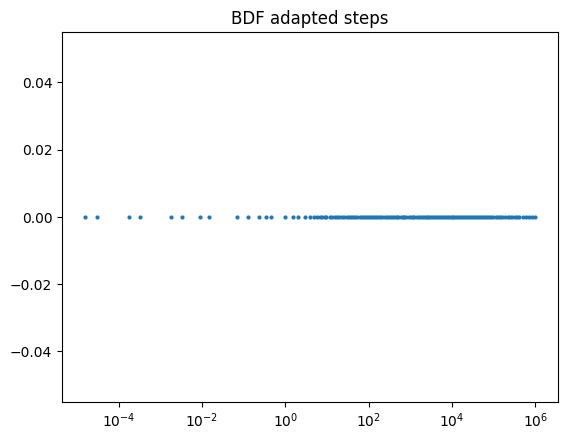

In [6]:
plt.semilogx(time,time*0,'o',markersize=2)
plt.title("BDF adapted steps")
plt.show();

In [7]:
M = len(time)
N = min(10,M)

which_idxs = lambda n, m: np.rint(
      np.linspace(1,m, min(n,m))-1).astype(int) 

coarse_time = time[which_idxs(N+1,M)]
initial_guesses = sol[:,which_idxs(N+1,M)]
dts = np.diff(coarse_time)

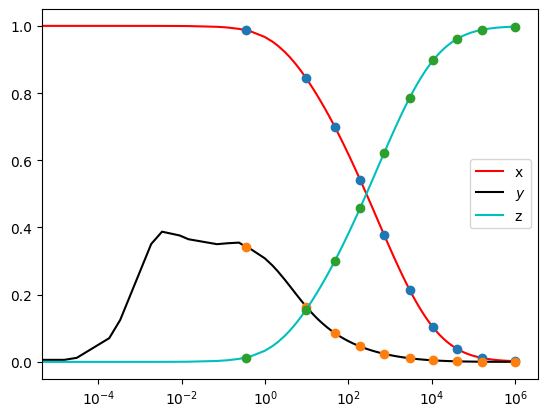

In [8]:
fact = 1e4 * (system=="Robert")

plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'o')
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'o')
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'o')
plt.legend()

In [9]:
def assembleData(t_0,t_1,y0):
    y0 = torch.from_numpy(y0.astype(np.float32)).unsqueeze(0)
    num_ics = 1
    num_times = 30
    
    t_ref = torch.linspace(t_0,t_1,num_times)
    loc_ref = y0.repeat(num_ics,1) #torch.abs(y0.repeat(num_ics,1) + (torch.rand(num_ics,d)*2-1)*y0)
    
    times = torch.zeros((num_ics*num_times,1))
    locs = torch.zeros((num_ics*num_times,d))
    for i in range(num_ics):
        for j in range(num_times):
            times[i * num_times + j] = t_ref[j]
            locs[i * num_times + j] = loc_ref[i]
    return times,locs

def trainNetwork(y0,t_0,t_1,net):
    
    time,ics = assembleData(t_0,t_1,y0)
    
    optimizer = Minimizer(net.parameters(),
                          method='l-bfgs',
                          tol=1e-12,
                          max_iter=2000,
                          disp=1)
    
    def closure():
        optimizer.zero_grad()
                
        Psi = lambda t,y0 : net(t,y0)
        output = net(time,ics)    
        Psi_t = vmap((jacfwd(Psi,argnums=0)))(time,ics).reshape(-1,d) * (t_1-t_0)
        vec = ode_torch(time,output)
        
        loss = torch.mean((Psi_t-vec)**2)
        return loss
        
    optimizer.step(closure)
    
    '''for component in range(d):
        def closure():
            optimizer.zero_grad()
                    
            Psi = lambda t,y0 : net(t,y0)
            output = net(time,ics)    
            Psi_t = torch.sum((jacfwd(Psi,argnums=0))(time,ics) * (t_1-t_0),dim=(0,1))[:,component:component+1]
            vec = ode_torch(time,output)[:,component:component+1]
            
            loss = torch.mean((Psi_t-vec)**2)
            return loss
            
        optimizer.step(closure)'''
    net.eval();
    

In [10]:
networks = []
for n in range(N):
    networks.append(network(coarse_time[n],coarse_time[n+1]))
    #trainNetwork(initial_guesses[:,n],coarse_time[n],coarse_time[n+1],networks[n])

In [11]:
coarse_preds = np.zeros((d,N+1))
coarse_preds[:,0] = initial_guesses[:,0]
for n in range(N):
    tt = torch.tensor([[dts[n]]],dtype=torch.float32)
    yy = torch.from_numpy(initial_guesses[:,n].astype(np.float32)).unsqueeze(0)
    coarse_preds[:,n+1] = networks[n](tt,yy)[0].detach().cpu().numpy()

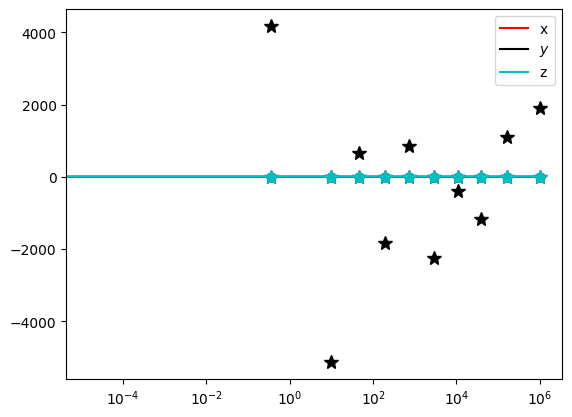

In [12]:
plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'ro')
plt.semilogx(coarse_time,coarse_preds[0],'r*',markersize=10)
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'ko')
plt.semilogx(coarse_time,coarse_preds[1]*fact,'k*',markersize=10)
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'co')
plt.semilogx(coarse_time,coarse_preds[2],'c*',markersize=10)
plt.legend()
plt.show();

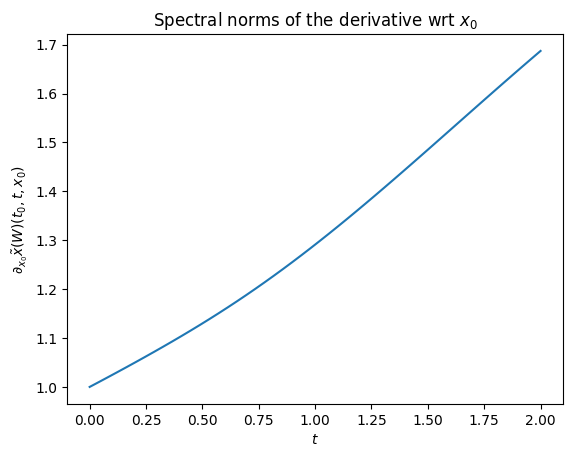

In [13]:
batch = 50
t_final = 2
timeArray = torch.linspace(0,t_final,batch).unsqueeze(1)
ic = torch.from_numpy(sol[:,0:1].astype(np.float32)).reshape(1,3).repeat(batch,1)
derivatives = networks[0].derivative_x0(timeArray,ic)
norms_derivative_x0 = torch.linalg.norm(derivatives,dim=(1,2),ord=2)
plt.plot(timeArray.flatten().detach().numpy(),norms_derivative_x0.detach().numpy())
plt.title(r"Spectral norms of the derivative wrt $x_0$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\partial_{x_0}\tilde{x}(W)(t_0,t,x_0)$")
plt.show();

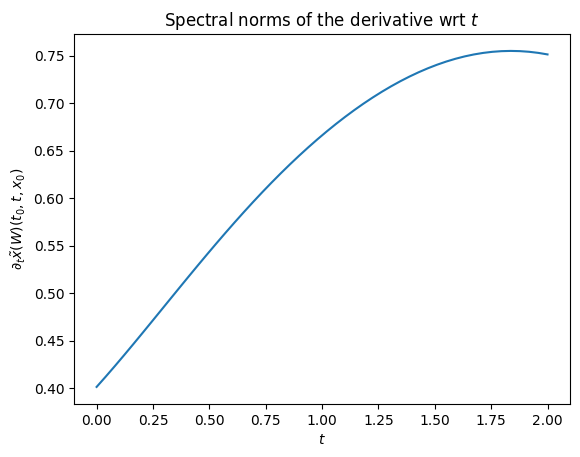

In [14]:
batch = 50
t_final = 2
timeArray = torch.linspace(0,t_final,batch).unsqueeze(1)
ic = torch.from_numpy(sol[:,0:1].astype(np.float32)).reshape(1,3).repeat(batch,1)
derivatives = networks[0].derivative_t(timeArray,ic)
norms_derivative_t = torch.linalg.norm(derivatives,dim=(1),ord=2)
plt.plot(timeArray.flatten().detach().numpy(),norms_derivative_t.detach().numpy())
plt.title(r"Spectral norms of the derivative wrt $t$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\partial_{t}\tilde{x}(W)(t_0,t,x_0)$")
plt.show();

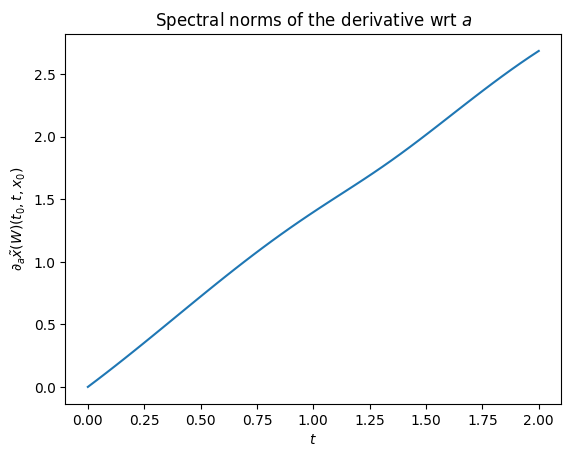

In [15]:
batch = 50
t_final = 2
timeArray = torch.linspace(0,t_final,batch).unsqueeze(1)
ic = torch.from_numpy(sol[:,0:1].astype(np.float32)).reshape(1,3).repeat(batch,1)
derivatives = networks[0].derivative_a(timeArray,ic)
norms_derivative_a = torch.linalg.norm(derivatives,dim=(1,2),ord=2)
plt.plot(timeArray.flatten().detach().numpy(),norms_derivative_a.detach().numpy())
plt.title(r"Spectral norms of the derivative wrt $a$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\partial_{a}\tilde{x}(W)(t_0,t,x_0)$")
plt.show();

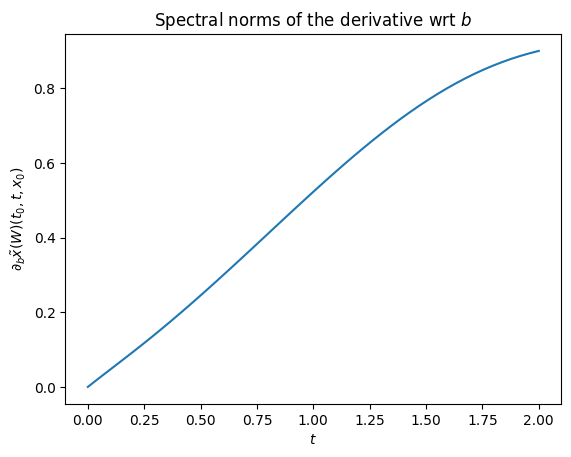

In [16]:
batch = 50
t_final = 2
timeArray = torch.linspace(0,t_final,batch).unsqueeze(1)
ic = torch.from_numpy(sol[:,0:1].astype(np.float32)).reshape(1,3).repeat(batch,1)
derivatives = networks[0].derivative_b(timeArray,ic)
norms_derivative_b = torch.linalg.norm(derivatives,dim=(1,2),ord=2)
plt.plot(timeArray.flatten().detach().numpy(),norms_derivative_b.detach().numpy())
plt.title(r"Spectral norms of the derivative wrt $b$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\partial_{b}\tilde{x}(W)(t_0,t,x_0)$")
plt.show();

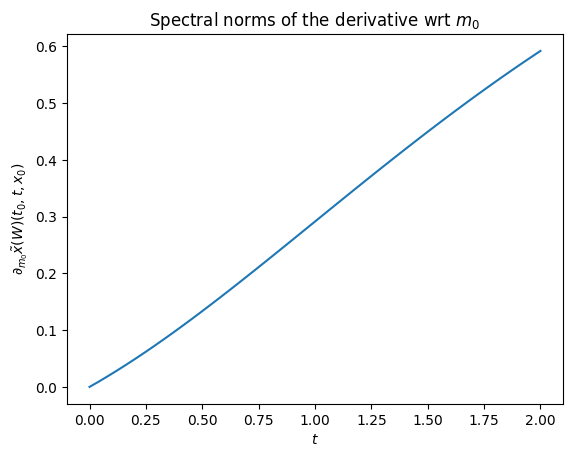

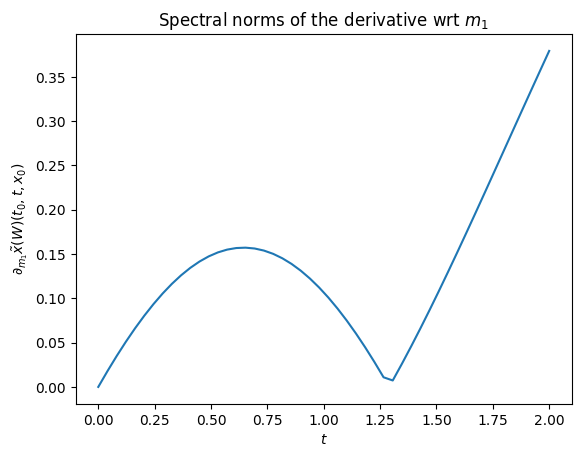

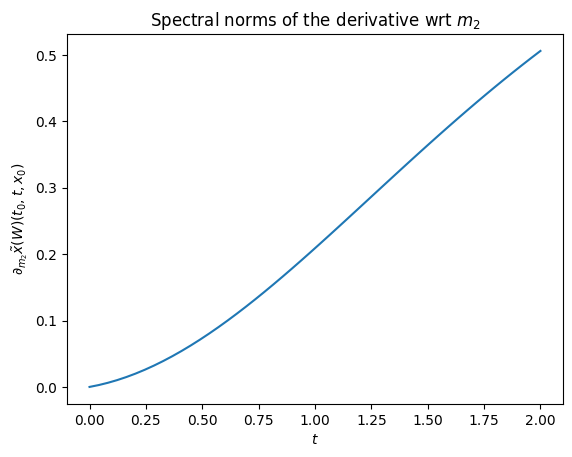

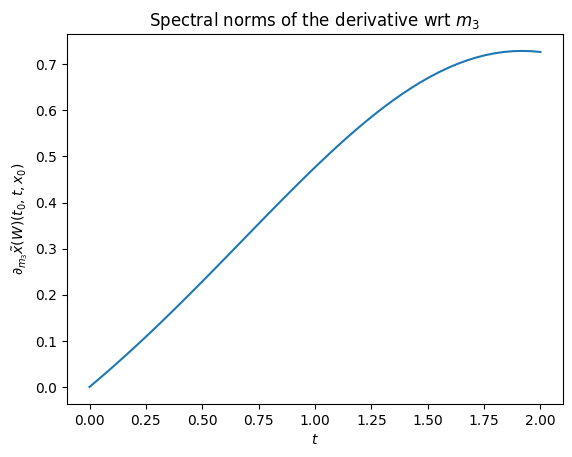

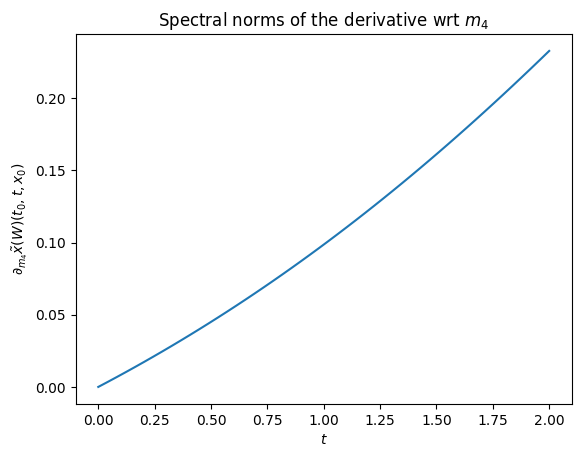

In [17]:
batch = 50
t_final = 2
timeArray = torch.linspace(0,t_final,batch).unsqueeze(1)
ic = torch.from_numpy(sol[:,0:1].astype(np.float32)).reshape(1,3).repeat(batch,1)
for i in range(networks[0].num_hidden):
    derivatives = networks[0].derivative_mi(timeArray,ic,i)
    norms_derivative_mi = torch.linalg.norm(derivatives,dim=(1,2),ord=2)
    plt.plot(timeArray.flatten().detach().numpy(),norms_derivative_mi.detach().numpy())
    plt.title(rf"Spectral norms of the derivative wrt $m_{i}$")
    plt.xlabel(r"$t$")
    plt.ylabel(rf"$\partial_{{m_{i}}}\tilde{{x}}(W)(t_0,t,x_0)$")
    plt.show();

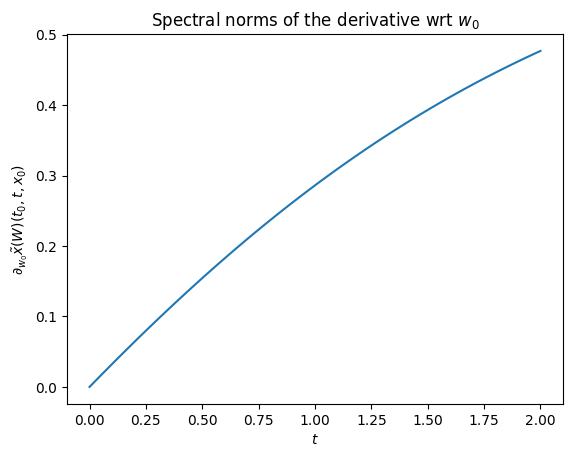

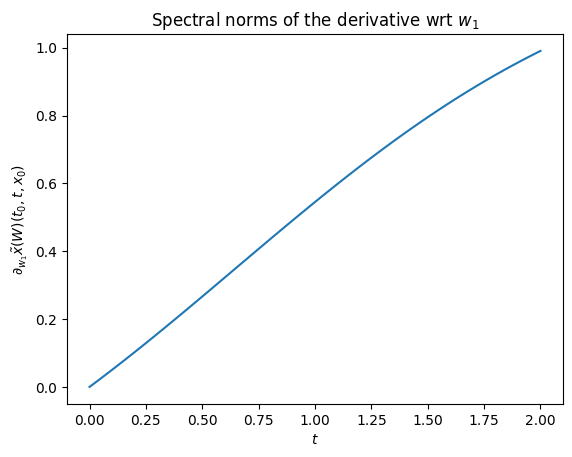

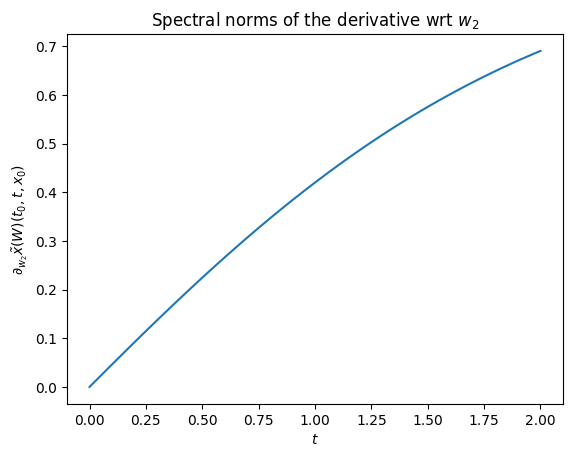

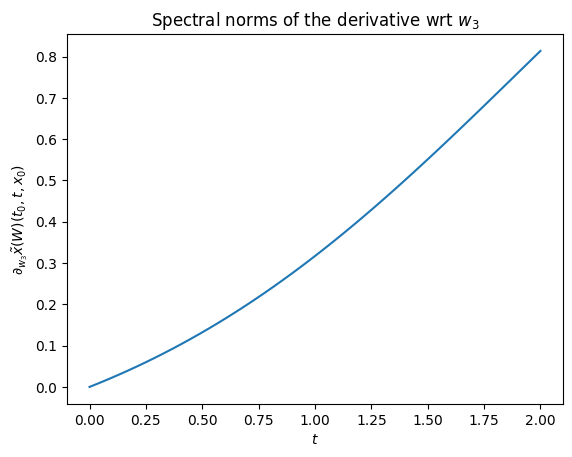

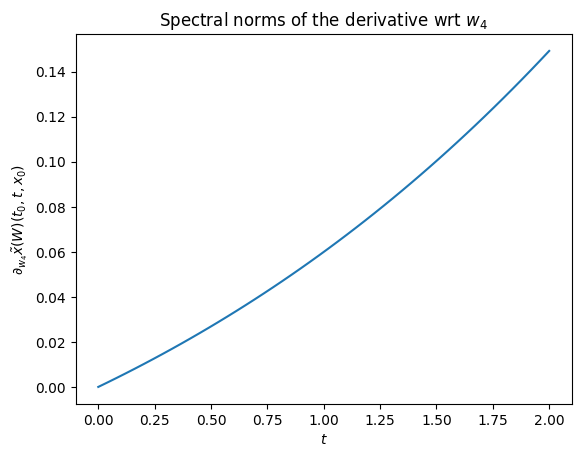

In [20]:
batch = 50
t_final = 2
timeArray = torch.linspace(0,t_final,batch).unsqueeze(1)
ic = torch.from_numpy(sol[:,0:1].astype(np.float32)).reshape(1,3).repeat(batch,1)
for i in range(networks[0].num_hidden):
    derivatives = networks[0].derivative_wi(timeArray,ic,i)
    norms_derivative_wi = torch.linalg.norm(derivatives,dim=(1,2),ord=2)
    plt.plot(timeArray.flatten().detach().numpy(),norms_derivative_wi.detach().numpy())
    plt.title(rf"Spectral norms of the derivative wrt $w_{i}$")
    plt.xlabel(r"$t$")
    plt.ylabel(rf"$\partial_{{w_{i}}}\tilde{{x}}(W)(t_0,t,x_0)$")
    plt.show();